In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append("/home/kenneth/Documents/slayerPytorch/src")

In [2]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import slayerSNN as snn
from slayerLoihi import spikeLayer
from quantizeParams import quantizeWeights
from learningStats import learningStats
import optimizer

In [3]:
class IBMGestureDataset(Dataset):
    def __init__(self, datasetPath, sampleFile, samplingTime, sampleLength):
        self.path = datasetPath 
        self.samplingTime = samplingTime
        self.nTimeBins    = int(sampleLength / samplingTime)
        samples = np.loadtxt(sampleFile).astype('int')
        self.samples = []
        for sample in samples:
            #if  sample[1]%2 !=0:#== 0:
            self.samples.append(sample)

    def __getitem__(self, index):
        # Read inoput and label
        # print(self.samples[index, 0])
        inputIndex  = self.samples[index][0]
        classLabel  = self.samples[index][1]# // 2
        # Read input spike
        inputSpikes = snn.io.read2Dspikes(
                        self.path + str(inputIndex.item()) + '.bs2'
                        ).toSpikeTensor(torch.zeros((2,128,128,self.nTimeBins)),
                        samplingTime=self.samplingTime)
        # Create one-hot encoded desired matrix
        desiredClass = torch.zeros((5, 1, 1, 1))
        desiredClass[classLabel,...] = 1

        return inputSpikes, desiredClass, classLabel

    def __len__(self):
        return len(self.samples)


In [4]:
# Define the network
class Network(torch.nn.Module):
    def __init__(self, netParams):
        super(Network, self).__init__()
        # initialize slayer
        slayer = snn.loihi(netParams['neuron'], netParams['simulation'])
        self.slayer = slayer
        # define network functions
        self.conv1 = slayer.conv( 2, 16, 5, padding=2, weightScale=10)
        self.conv2 = slayer.conv(16, 32, 3, padding=1, weightScale=50)
        self.fc1   = slayer.dense((8*8*32), 512)
        self.pool1 = slayer.pool(4)
        self.pool2 = slayer.pool(2)
        self.pool3 = slayer.pool(2)
        self.fc2   = slayer.dense(512, 5) #6


        self.conv1.weight.data = torch.FloatTensor(np.loadtxt('Trained/conv1Weights.txt').reshape(self.conv1.weight.shape))
        self.conv2.weight.data = torch.FloatTensor(np.loadtxt('Trained/conv2Weights.txt').reshape(self.conv2.weight.shape))
        self.fc1  .weight.data = torch.FloatTensor(np.loadtxt('Trained/fc1Weights.txt').reshape(self.fc1.weight.shape))
        #self.fc2  .weight.data = torch.FloatTensor(np.loadtxt('Trained/fc2Weights.txt').reshape(self.fc2.weight.shape))

    def forward(self, spikeInput):
        spike = self.slayer.spikeLoihi(self.pool1(spikeInput )) # 32, 32, 2
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.slayer.spikeLoihi(self.conv1(spike)) # 32, 32, 16
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.slayer.spikeLoihi(self.pool2(spike)) # 16, 16, 16
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.slayer.spikeLoihi(self.conv2(spike)) # 16, 16, 32
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.slayer.spikeLoihi(self.pool3(spike)) #  8,  8, 32
        spike = spike.reshape((spike.shape[0], -1, 1, 1, spike.shape[-1]))
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.slayer.spikeLoihi(self.fc1  (spike)) # 512
        spike = self.slayer.delayShift(spike, 1)
        
        spike = self.slayer.spikeLoihi(self.fc2  (spike)) # 11
        spike = self.slayer.delayShift(spike, 1)
        
        return spike
    
    def freeze(self):
        i = 0
        for param in self.parameters():
            if i<6:
                param.requires_grad = False
                print(param.requires_grad)
            else:
                print(param.data.size())
                torch.random.manual_seed(1)
                self.fc2.weight.data = torch.rand([5, 512, 1, 1, 1]).cuda()#param.data.size()).cuda()
                self.fc2.weight.requires_grad = True
                print(self.fc2.weight.requires_grad)
            i = i+1

In [5]:
device = torch.device('cuda')
netParams = snn.params('network.yaml')
net = Network(netParams).to(device)

error = snn.loss(netParams, snn.loihi).to(device)

# Define optimizer module.
optimizer = torch.optim.Adam(net.parameters(), lr = 0.1, amsgrad = True)

testingSet = IBMGestureDataset(datasetPath ='/home/kenneth/Documents/slayerPytorch/exampleLoihi/03_IBMGesture/6classLearning/Test/', 
                               sampleFile  ='/home/kenneth/Documents/slayerPytorch/exampleLoihi/03_IBMGesture/6classLearning/Test/test.txt',
                               samplingTime=netParams['simulation']['Ts'],
                               sampleLength=1450)

testLoader  = DataLoader(dataset=testingSet , batch_size=1, shuffle=True, num_workers=1)

# Dataset and dataLoader instances.
trainingSet = IBMGestureDataset(datasetPath ='/home/kenneth/Documents/slayerPytorch/exampleLoihi/03_IBMGesture/6classLearning/Train1/', 
                               sampleFile  ='/home/kenneth/Documents/slayerPytorch/exampleLoihi/03_IBMGesture/6classLearning/Train1/train.txt',
                               samplingTime=netParams['simulation']['Ts'],
                               sampleLength=1450)
trainLoader = DataLoader(dataset=trainingSet, batch_size=1, shuffle=True, num_workers=1)

stats = learningStats()

Max PSP kernel: 711.5
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
Max PSP kernel: 711.5
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi


In [6]:
#net.load_state_dict(torch.load('Trained/dvsGesture.pt', map_location=device))
net.freeze()

False
False
False
False
False
False
torch.Size([5, 512, 1, 1, 1])
True


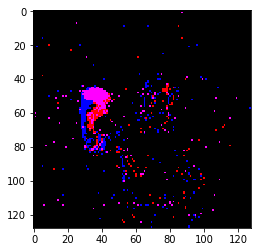

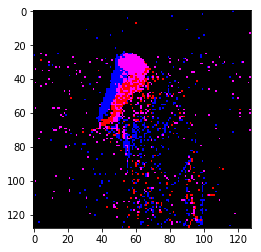

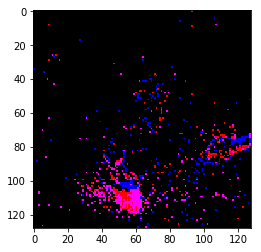

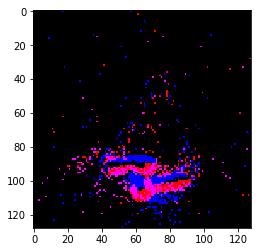

In [8]:
#Visualize the input spikes (first five samples).
for i in range(len(trainingSet)):
    input, target, label = trainingSet[i]
    snn.io.showTD(snn.io.spikeArrayToEvent(input.reshape((2, 128, 128, -1)).cpu().data.numpy()))

In [8]:
for epoch in range(10):
    tSt = datetime.now()

    # Training loop.
    for i, (input, target, label) in enumerate(trainLoader, 0):
        net.train()
        
        # Move the input and target to correct GPU.
        input  = input.to(device)
        target = target.to(device) 

        # Forward pass of the network.
        output = net.forward(input)

        # Gather the training stats.
        stats.training.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
        stats.training.numSamples     += len(label)

        # Calculate loss.
        loss = error.numSpikes(output, target)

        # Reset gradients to zero.
        optimizer.zero_grad()

        # Backward pass of the network.
        loss.backward()

        # Update weights.
        optimizer.step()

        # Gather training loss stats.
        stats.training.lossSum += loss.cpu().data.item()

        # Display training stats. (Suitable for normal python implementation)
        if i%10==0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())

    # Testing loop.
    # Same steps as Training loops except loss backpropagation and weight update.
    for i, (input, target, label) in enumerate(testLoader, 0):
        net.eval()
        
        input  = input.to(device)
        target = target.to(device) 

        output = net.forward(input)

        stats.testing.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
        stats.testing.numSamples     += len(label)

        loss = error.numSpikes(output, target)
        stats.testing.lossSum += loss.cpu().data.item()
        if i%10==0: stats.print(epoch, i)

    # Update testing stats.
    if epoch%10==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())
    stats.update()
    #if stats.training.bestLoss is True: torch.save(net.state_dict(), 'DataForReport/ibmGesturePure1Net.pt')


Epoch :          0(i =       0),     572.8140 ms elapsed
loss = 19.333                             accuracy = 1                        

Epoch :          0(i =      10),    2976.2320 ms elapsed
loss = 8.6084e+11                         accuracy = 0.36364                  

Epoch :          0(i =      20),    5329.1110 ms elapsed
loss = 4.6574e+11                         accuracy = 0.47619                  

Epoch :          0(i =      30),    7682.0400 ms elapsed
loss = 3.166e+11                          accuracy = 0.41935                  

Epoch :          0(i =      40),   10056.9130 ms elapsed
loss = 2.4055e+11                         accuracy = 0.36585                  

Epoch :          0(i =      50),   12444.1860 ms elapsed
loss = 1.948e+11                          accuracy = 0.33333                  

Epoch :          0(i =      60),   14816.0620 ms elapsed
loss = 1.6294e+11                         accuracy = 0.37705                  

Epoch :          0(i =      70),   17176


Epoch :          2(i =      40),    9559.2570 ms elapsed
loss = 12.842      (min = 5.6109e+08 )    accuracy = 0.58537  (max = 0.41    )

Epoch :          2(i =      50),   11696.9340 ms elapsed
loss = 12.093      (min = 5.6109e+08 )    accuracy = 0.60784  (max = 0.41    )

Epoch :          2(i =      60),   13840.4460 ms elapsed
loss = 11.387      (min = 5.6109e+08 )    accuracy = 0.65574  (max = 0.41    )

Epoch :          2(i =      70),   16090.8720 ms elapsed
loss = 11.759      (min = 5.6109e+08 )    accuracy = 0.61972  (max = 0.41    )

Epoch :          2(i =      80),   18262.5370 ms elapsed
loss = 11.675      (min = 5.6109e+08 )    accuracy = 0.60494  (max = 0.41    )

Epoch :          2(i =      90),   20508.4420 ms elapsed
loss = 11.454      (min = 5.6109e+08 )    accuracy = 0.61538  (max = 0.41    )

Epoch :          2(i =       0)
loss = 4.2098e+06  (min = 5.6109e+08 )    accuracy = 0.62     (max = 0.41    )
loss = 6.7517      (min = 3.1079e+08 )

Epoch :          2(i =    


Epoch :          4(i =       0)
loss = 2.6902e+07  (min = 4.2098e+06 )    accuracy = 0.68     (max = 0.68    )
loss = 11.253      (min = 3.1079e+08 )    accuracy = 1        (max = 0.48333 )

Epoch :          4(i =      10)
loss = 2.6902e+07  (min = 4.2098e+06 )    accuracy = 0.68     (max = 0.68    )
loss = 1.0458e+08  (min = 3.1079e+08 )    accuracy = 0.63636  (max = 0.48333 )

Epoch :          4(i =      20)
loss = 2.6902e+07  (min = 4.2098e+06 )    accuracy = 0.68     (max = 0.68    )
loss = 5.4778e+07  (min = 3.1079e+08 )    accuracy = 0.66667  (max = 0.48333 )

Epoch :          4(i =      30)
loss = 2.6902e+07  (min = 4.2098e+06 )    accuracy = 0.68     (max = 0.68    )
loss = 5.1057e+08  (min = 3.1079e+08 )    accuracy = 0.58065  (max = 0.48333 )

Epoch :          4(i =      40)
loss = 2.6902e+07  (min = 4.2098e+06 )    accuracy = 0.68     (max = 0.68    )
loss = 3.8604e+08  (min = 3.1079e+08 )    accuracy = 0.5122   (max = 0.48333 )

Epoch :          4(i =      50)
loss = 2.690

KeyboardInterrupt: 